# Using the Crossref API


https://github.com/CrossRef/rest-api-doc

In [478]:
import requests
import time

In [479]:
requesteddoi = {}

In [480]:
def requestDoi(doi):
    if doi in requesteddoi:
        return requesteddoi[doi]
    else:
        url = 'https://api.crossref.org/works/'

        params = { 'mailto':'xdze2.me@gmail.com'}
        response = requests.get(url+doi, params=params)
        time.sleep( 10 )
        if not response.ok:
            print('query error')
            return None
        else:
            response = response.json()
            message = response['message']
            
            requesteddoi[doi] = message
            return message

In [481]:
def getRefList(doi):
    message = requestDoi(doi)
    references = message.get('reference', [])
    referencesWithDoi = { ref['DOI'] for ref in references if 'DOI' in ref }
    # print(doi, len(referencesWithDoi))
    return list( referencesWithDoi )

In [482]:
def printInfo(doi):
    message = requestDoi(doi)
    doi = message['DOI']
    title = message['title']
    print( title[0], '[%s]'%doi )

In [483]:
doi = "10.1063/1.1654632"
printInfo(doi)

refs = getRefList(doi)

Dislocations in thermally stressed silicon wafers [10.1063/1.1654632]


In [484]:
message = requestDoi(refs[0])

In [485]:
len(requesteddoi)

2

In [486]:
from graphviz import Digraph
from IPython.display import Image, display

In [487]:
dot = Digraph(comment='hello', format='png')

In [496]:
class Referencesgraph():
    
    def __init__(self, doi):
        self.nodes = {doi:{ 'gen':0, 'citedBy':[] } }
        
    
    def grow(self):
        nodes = self.nodes
        lastGen = self.lastGen()
        lastGenNodes = [ doi for doi, info in nodes.items() if info['gen']==lastGen ]
        
        for doi in lastGenNodes:
            print('fetch %s' % doi, end='\r')
            references = getRefList(doi)
            
            self.nodes[doi]['refs'] = references
            for ref in references:
                if ref not in self.nodes:
                    self.nodes[ref] = {'gen':lastGen+1, 'citedBy':[doi] }
                else:
                    self.nodes[ref]['citedBy'].append( doi )
                
        print('- done -')
                   
            
    def lastGen(self):
        nodes = self.nodes
        return max( n['gen'] for n in nodes.values() )
    
    
    
    def degree(self, node):
        return len( self.nodes[node].get('refs', []) ) + len( self.nodes[node].get('citedBy', []) )
        
        
    def nodesVisitedTwice(self):
        """ List of nodes visited at least twice
        """
        isVisitedTwice = lambda node: len(node.get('citedBy', []))>1
        return [ doi for doi, node in self.nodes.items() if isVisitedTwice(node) ]

        

In [497]:
doi = "10.1063/1.1654632"
refgraph = Referencesgraph(doi)

In [498]:
refgraph.nodes

{'10.1063/1.1654632': {'citedBy': [], 'gen': 0}}

In [516]:
refgraph.grow()

refgraph.lastGen()

- done -.1063/1.1736034/39/2/306b03882.x


3

In [517]:
refgraph.nodesVisitedTwice()

['10.1080/14786435708242742',
 '10.1016/0001-6160(57)90164-5',
 '10.1063/1.1735455',
 '10.1103/PhysRev.97.1521',
 '10.1103/PhysRev.75.865',
 '10.1016/0001-6160(56)90071-2',
 '10.1063/1.1728256',
 '10.1063/1.1722229',
 '10.1002/j.1538-7305.1958.tb03882.x',
 '10.1063/1.1722034',
 '10.1063/1.1728769',
 '10.1103/PhysRev.106.418',
 '10.1063/1.1728767',
 '10.1098/rspa.1956.0063',
 '10.1002/j.1538-7305.1956.tb02394.x',
 '10.1063/1.1728435',
 '10.1103/PhysRev.93.1182',
 '10.1063/1.1702390',
 '10.1063/1.1721711',
 '10.1103/PhysRev.96.28',
 '10.1098/rsta.1960.0013']

In [533]:
nodesToDraw = []
linksToDraw = []
nodesToCheck = refgraph.nodesVisitedTwice()

while nodesToCheck:
    doi = nodesToCheck.pop()
    nodesToDraw.append(doi)
    
    for citing in refgraph.nodes[doi]['citedBy']:
        
        linksToDraw.append( (doi, citing) )
        if citing not in nodesToDraw and citing not in nodesToCheck:
            nodesToCheck.append( citing )

In [534]:
linksToDraw

[('10.1098/rsta.1960.0013', '10.1063/1.1713768'),
 ('10.1098/rsta.1960.0013', '10.1063/1.1702622'),
 ('10.1063/1.1702622', '10.1063/1.1713768'),
 ('10.1063/1.1713768', '10.1063/1.1654632'),
 ('10.1103/PhysRev.96.28', '10.1103/PhysRev.97.1521'),
 ('10.1103/PhysRev.96.28', '10.1063/1.1722419'),
 ('10.1103/PhysRev.96.28', '10.1063/1.1723060'),
 ('10.1063/1.1723060', '10.1063/1.1728435'),
 ('10.1063/1.1722419', '10.1063/1.1728435'),
 ('10.1063/1.1721711', '10.1063/1.1722419'),
 ('10.1063/1.1721711', '10.1063/1.1736034'),
 ('10.1063/1.1736034', '10.1063/1.1728435'),
 ('10.1063/1.1702390', '10.1063/1.1728256'),
 ('10.1063/1.1702390', '10.1063/1.1735682'),
 ('10.1063/1.1735682', '10.1063/1.1728435'),
 ('10.1103/PhysRev.93.1182', '10.1063/1.1722419'),
 ('10.1103/PhysRev.93.1182', '10.1063/1.1722229'),
 ('10.1063/1.1728435', '10.1063/1.1654632'),
 ('10.1063/1.1728435', '10.1063/1.1713768'),
 ('10.1063/1.1728435', '10.1063/1.1728769'),
 ('10.1002/j.1538-7305.1956.tb02394.x', '10.1063/1.1657151')

In [535]:
colorGen = ['red', 'blue', 'black', 'magenta']

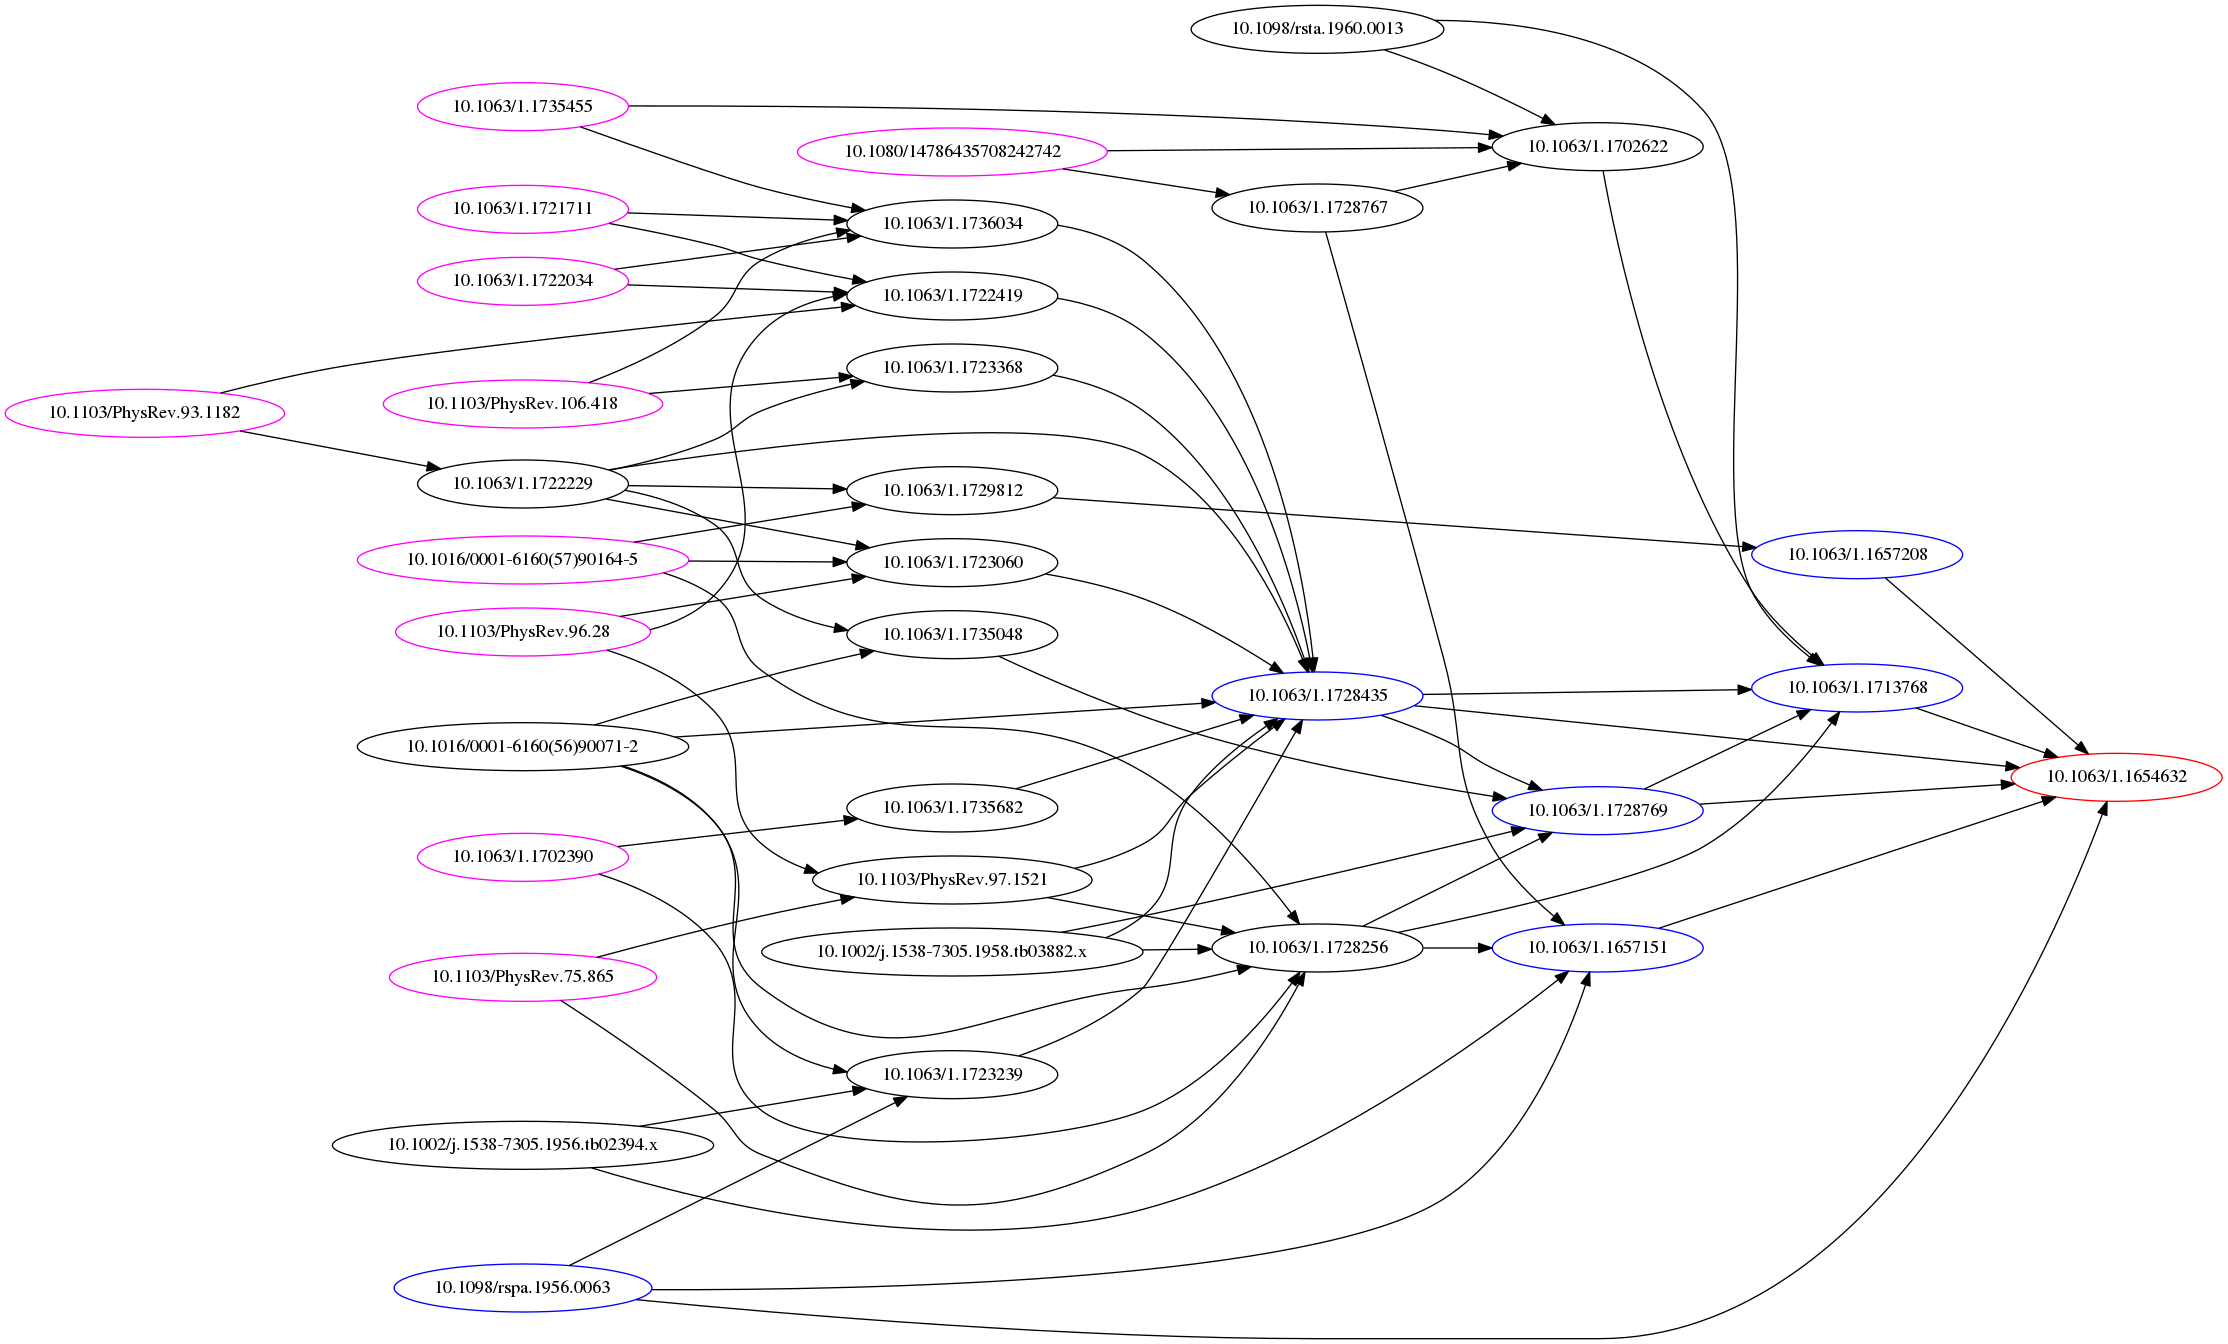

In [536]:
DG = Digraph(comment='hello', format='png')
DG.graph_attr['rankdir'] = 'LR'

for doi in nodesToDraw:
    info =  refgraph.nodes[doi]
    DG.node(doi, color=colorGen[info['gen']])
    
for source, target in linksToDraw:
    DG.edge(source, target)  
            
plt = Image(DG.render())
display(plt)

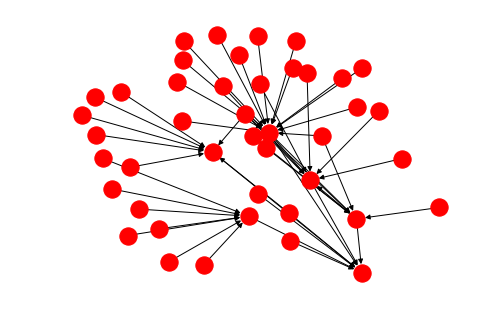

In [537]:
import networkx as nx

G = nx.DiGraph()
for source, target in AllGenRefs:
    
    if outDegree[source]>0:
        G.add_edge(source, target) 

nx.drawing.draw(G) 